# Investigating Drive Strengths

We split this section into weak, moderate, and strong drive strengths, w.r.t. the following ranges:
- 0.01 - 0.2: Weak Drive
- 0.2 - 0.5: Moderate Drive
- 0.5 - 2: Strong Drive

Note that we start with all experiments being in a transversal field, followed by a non-transversal field.
Below are the helper functions and libraries being used. Scroll down for the experiments themselves

In [1]:
# Importing Libraries

%matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from qutip import *

In [2]:
# Baselines for code
rabi   = 0.10 * np.pi   # base drive amplitude
omega_d = 1.0 * np.pi * 0.3372   # drive frequency

## In this investigation, we modify the two values above.

omega_0 = 1.0 * np.pi * 0.3373   # resonance frequency
theta = 0.5 * np.pi
g2 = 0.0 # noise
g1 = 0.0

psi0 = basis(2,0)
tlist = np.linspace(0,5000,10000)

solver = "me"

In [3]:
def qubit_integrate_labframe(omega_0, omega_d, rabi, theta,psi0, solver, phi = 0, g1 = 0, g2 = 0):

    H0 = (omega_0/2) * sigmaz()
    H1 = 2 * rabi * np.sin(theta) * sigmax()
    H2 = 2 * rabi * np.cos(theta) * sigmaz()
    
    def H1_coeff(t, args):
        return np.cos(omega_d*t+phi)
        
    def H2_coeff(t, args):
        return np.cos(omega_d*t+phi)
    
    # collapse operators
    c_ops = []

    if g1 > 0.0:
        c_ops.append(np.sqrt(g1) * sigmam())

    if g2 > 0.0:
        c_ops.append(np.sqrt(g2) * sigmaz())

    e_ops = [sigmax(), sigmay(), sigmaz()]
    
    H = [H0, [H1,H1_coeff],  [H2,H2_coeff]]
    
    if solver == "me": # master equation
        output = mesolve(H, psi0, tlist, c_ops, e_ops)  
    elif solver == "es": # exact schrodinger
        output = essolve(H, psi0, tlist, c_ops, e_ops)  
    elif solver == "mc": # monte carlo
        ntraj = 250
        output = mcsolve(H, psi0, tlist, ntraj, c_ops, e_ops)  
    else:
        raise ValueError("unknown solver")
        
    return output.expect[0], output.expect[1], output.expect[2] # Time-dependent expectation values of the qubit’s Pauli operators

### Additional Functions

To help with analysis, I've designed additional helper functions to look at the fourier transform of different frequencies, making it easier to analyse. These are defined below:

In [4]:
import numpy as np
from scipy.signal import find_peaks

def compute_psd_and_peaks(omega_0,rabi_list,theta,psi0,solver,tlist,prominence_frac=0.05):
    
    psd_results = []
    results_summary = {}
    all_peak_freqs = set()

    for rabi in rabi_list:
        sx, sy, sz = qubit_integrate_labframe(
            omega_0=omega_0,
            omega_d=rabi / (2*np.pi),
            rabi=rabi,
            theta=theta,
            psi0=psi0,
            solver=solver
        )

        freqs = np.fft.fftfreq(len(tlist), tlist[1] - tlist[0])
        psd = np.abs(np.fft.fft(sz))**2
        psd_results.append(psd)

        # Positive frequencies only (spectrum is symmetric)
        mask = freqs > 0
        freqs_pos = freqs[mask]
        psd_pos = psd[mask]

        peaks, _ = find_peaks(
            psd_pos,
            prominence=np.max(psd_pos) * prominence_frac
        )

        peak_data = [(freqs_pos[p], psd_pos[p]) for p in peaks]
        results_summary[rabi] = peak_data

        for f, _ in peak_data:
            all_peak_freqs.add(f)

    return freqs, psd_results, results_summary, all_peak_freqs


In [5]:
import matplotlib.pyplot as plt

def plot_psd_and_print_peaks(freqs,psd_results,results_summary,all_peak_freqs,rabi_list,omega_d,max_ticks=12):
    # -------------------------
    # Plot Power Spectral Density
    # -------------------------

    plt.figure(figsize=(16, 10))

    for psd, rabi in zip(psd_results, rabi_list):
        plt.plot(freqs[freqs > 0], psd[freqs > 0],
                 label=f"Ω={rabi/np.pi:.2f}π")

    # X-axis ticks based on unique peak frequencies
    unique_freqs = sorted(all_peak_freqs)
    if len(unique_freqs) > max_ticks:
        step = len(unique_freqs) // max_ticks
        unique_freqs = unique_freqs[::step]

    plt.xticks(unique_freqs, rotation=45)
    plt.xlabel("Frequency")
    plt.ylabel("PSD")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\nSpectral Peaks by Drive Strength:\n")

    for rabi, peaks in results_summary.items():
        print(f"{rabi/np.pi:.2f}π:")
        if not peaks:
            print("  (No significant peaks found)")
        for f, amp in peaks:
            print(f"  (Freq: {f:.3f}, Amp: {amp:.3e})")
        print()


## Transversal Scenarios

In the following section, we only deal with driving fields that are purely transversal.

### Weak Drives

We start with weak drives, looking at a range between 0.01 and 0.2 as a drive amplitude scalar.

C:\Users\sachh\anaconda3\Lib\site-packages\qutip\solver\solver_base.py:598: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


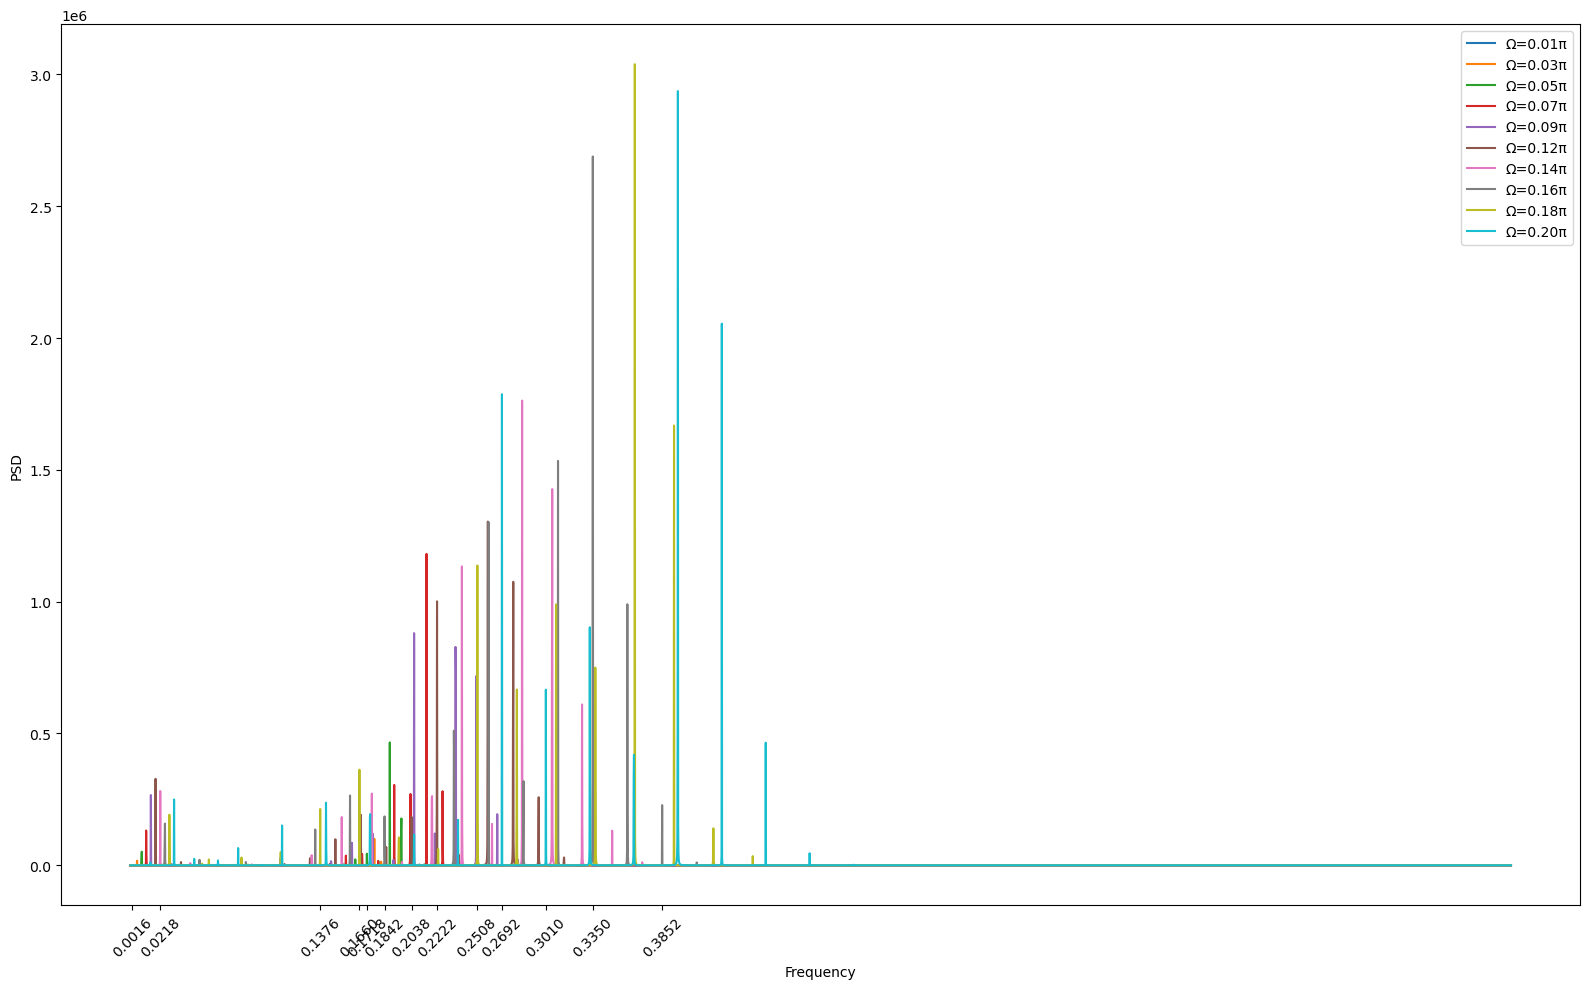


Spectral Peaks by Drive Strength:

0.01π:
  (Freq: 0.002, Amp: 2.942e+02)
  (Freq: 0.168, Amp: 6.070e+02)
  (Freq: 0.170, Amp: 1.189e+03)

0.03π:
  (Freq: 0.005, Amp: 1.732e+04)
  (Freq: 0.167, Amp: 1.003e+04)
  (Freq: 0.172, Amp: 5.063e+03)
  (Freq: 0.177, Amp: 1.005e+05)
  (Freq: 0.182, Amp: 1.390e+04)

0.05π:
  (Freq: 0.008, Amp: 5.147e+04)
  (Freq: 0.171, Amp: 4.402e+04)
  (Freq: 0.188, Amp: 4.661e+05)
  (Freq: 0.196, Amp: 1.775e+05)
  (Freq: 0.205, Amp: 6.668e+04)

0.07π:
  (Freq: 0.012, Amp: 1.320e+05)
  (Freq: 0.191, Amp: 3.048e+05)
  (Freq: 0.203, Amp: 2.705e+05)
  (Freq: 0.215, Amp: 1.181e+06)
  (Freq: 0.226, Amp: 2.809e+05)

0.09π:
  (Freq: 0.015, Amp: 2.664e+05)
  (Freq: 0.161, Amp: 8.532e+04)
  (Freq: 0.176, Amp: 1.200e+05)
  (Freq: 0.206, Amp: 8.807e+05)
  (Freq: 0.221, Amp: 1.207e+05)
  (Freq: 0.236, Amp: 8.284e+05)
  (Freq: 0.251, Amp: 7.187e+05)
  (Freq: 0.266, Amp: 1.939e+05)

0.12π:
  (Freq: 0.018, Amp: 3.281e+05)
  (Freq: 0.149, Amp: 9.877e+04)
  (Freq: 0.167, Amp: 

In [6]:
theta = np.pi / 2

# Upper limit of 10 because mpl cycle colors afterwards
rabi_list = np.linspace(0.01, 0.20, 10) * np.pi

freqs, psd_results, results_summary, all_peak_freqs = compute_psd_and_peaks(omega_0,rabi_list,theta,psi0,solver,tlist)
plot_psd_and_print_peaks(freqs,psd_results,results_summary,all_peak_freqs,rabi_list,omega_d)

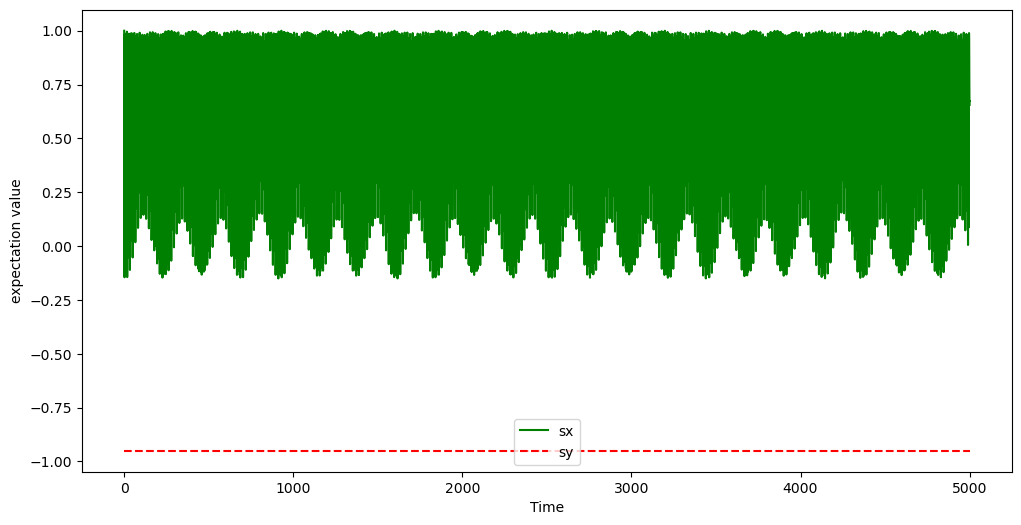

In [7]:
# Playground - Weak Drive Strengths:

# MODIFY ONLY THE BELOW LINE ------
rabi_strength = np.pi * 0.3852
# MODIFY ONLY THE ABOVE LINE ------

omega_d = rabi_strength / (2 * np.pi)
_, _, sz_brwa_d = qubit_integrate_labframe(omega_0, omega_d, rabi, theta, psi0,"me", g1, g2)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(tlist, np.real(sz_brwa_d), 'g')
ax.plot((np.min(tlist),np.max(tlist)),(-0.95, -0.95), 'r--' )
ax.legend(("sx", "sy", "sz"))
ax.set_xlabel('Time')
ax.set_ylabel('expectation value');

#### Analysis: 

We notice here that each field strength has its corresponding frequency where fluctuations are highest, and remain mostly flat throughout the rest of the graph, observing 10 major peaks across the 10 trials. However, we notice non-overlapping responses close to each other, with these entries being "fractional harmonics" of the most powerful frequency (i.e. 2/3 harmonic, 3/4 harmonic etc).

None of the different drive strengths in this region show significant changes in the graph ( seen above ). This holds true for time ranges of 0 to 100, 1000, 5000, and 10000 units time. 


### Moderate Drive Strength



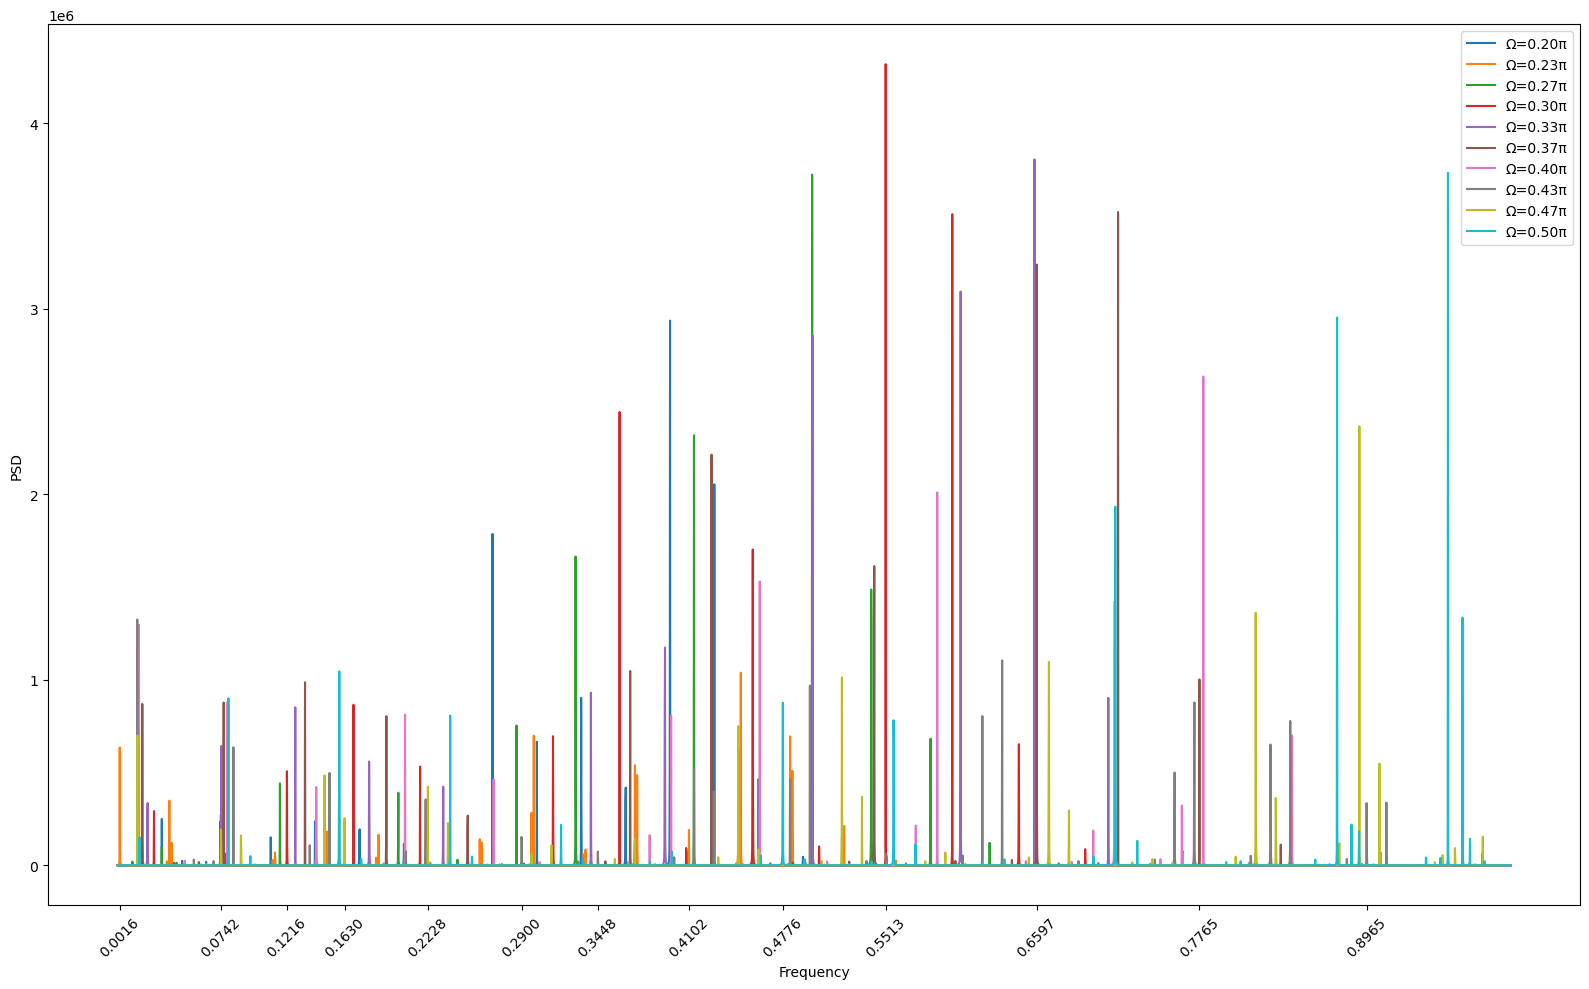


Spectral Peaks by Drive Strength:

0.20π:
  (Freq: 0.032, Amp: 2.499e+05)
  (Freq: 0.110, Amp: 1.510e+05)
  (Freq: 0.142, Amp: 2.373e+05)
  (Freq: 0.174, Amp: 1.941e+05)
  (Freq: 0.237, Amp: 1.723e+05)
  (Freq: 0.269, Amp: 1.787e+06)
  (Freq: 0.301, Amp: 6.661e+05)
  (Freq: 0.333, Amp: 9.029e+05)
  (Freq: 0.365, Amp: 4.188e+05)
  (Freq: 0.397, Amp: 2.937e+06)
  (Freq: 0.428, Amp: 2.055e+06)
  (Freq: 0.460, Amp: 4.651e+05)

0.23π:
  (Freq: 0.002, Amp: 6.351e+05)
  (Freq: 0.037, Amp: 3.484e+05)
  (Freq: 0.039, Amp: 1.220e+05)
  (Freq: 0.076, Amp: 6.338e+04)
  (Freq: 0.113, Amp: 6.928e+04)
  (Freq: 0.149, Amp: 8.023e+04)
  (Freq: 0.150, Amp: 1.822e+05)
  (Freq: 0.187, Amp: 1.646e+05)
  (Freq: 0.260, Amp: 1.402e+05)
  (Freq: 0.262, Amp: 1.225e+05)
  (Freq: 0.297, Amp: 2.832e+05)
  (Freq: 0.299, Amp: 6.985e+05)
  (Freq: 0.334, Amp: 5.943e+04)
  (Freq: 0.336, Amp: 8.569e+04)
  (Freq: 0.371, Amp: 5.395e+05)
  (Freq: 0.373, Amp: 4.863e+05)
  (Freq: 0.409, Amp: 7.200e+04)
  (Freq: 0.410, Amp: 

In [8]:
rabi_list = np.linspace(0.2, 0.5, 10) * np.pi

freqs, psd_results, results_summary, all_peak_freqs = compute_psd_and_peaks(omega_0,rabi_list,theta,psi0,solver,tlist)
plot_psd_and_print_peaks(freqs,psd_results,results_summary,all_peak_freqs,rabi_list,omega_d)

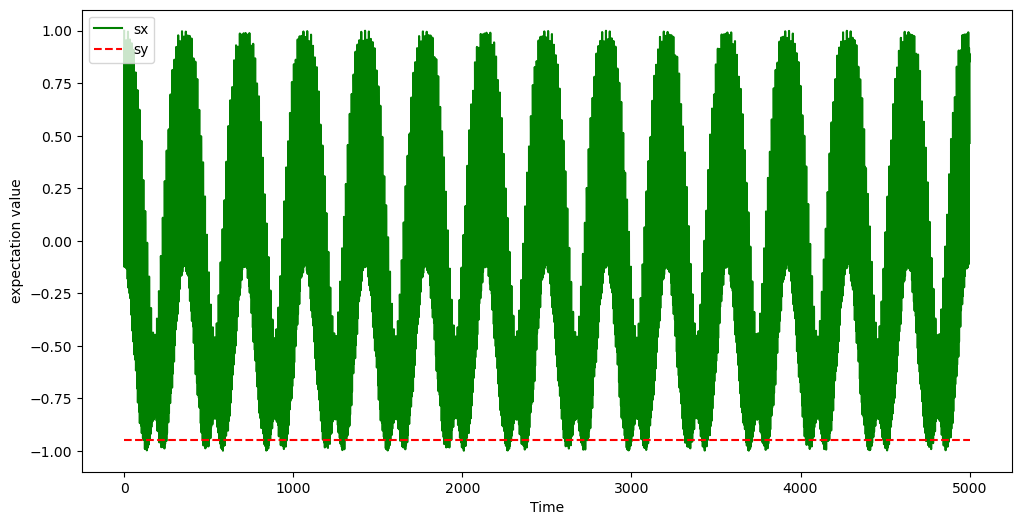

In [9]:
# Playground - Moderate Drive Strengths:

# MODIFY ONLY THE BELOW LINE ------
rabi_strength = np.pi * 0.5513
# MODIFY ONLY THE ABOVE LINE ------

omega_d = rabi_strength / (2 * np.pi)
_, _, sz_brwa_d = qubit_integrate_labframe(omega_0, omega_d, rabi, theta, psi0,"me", g1, g2)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(tlist, np.real(sz_brwa_d), 'g')
ax.plot((np.min(tlist),np.max(tlist)),(-0.95, -0.95), 'r--' )
ax.legend(("sx", "sy", "sz"))
ax.set_xlabel('Time')
ax.set_ylabel('expectation value');

#### Analysis: Moderate Drives

In this, we see significant overlap between spectral densities. 

### Strong Drives

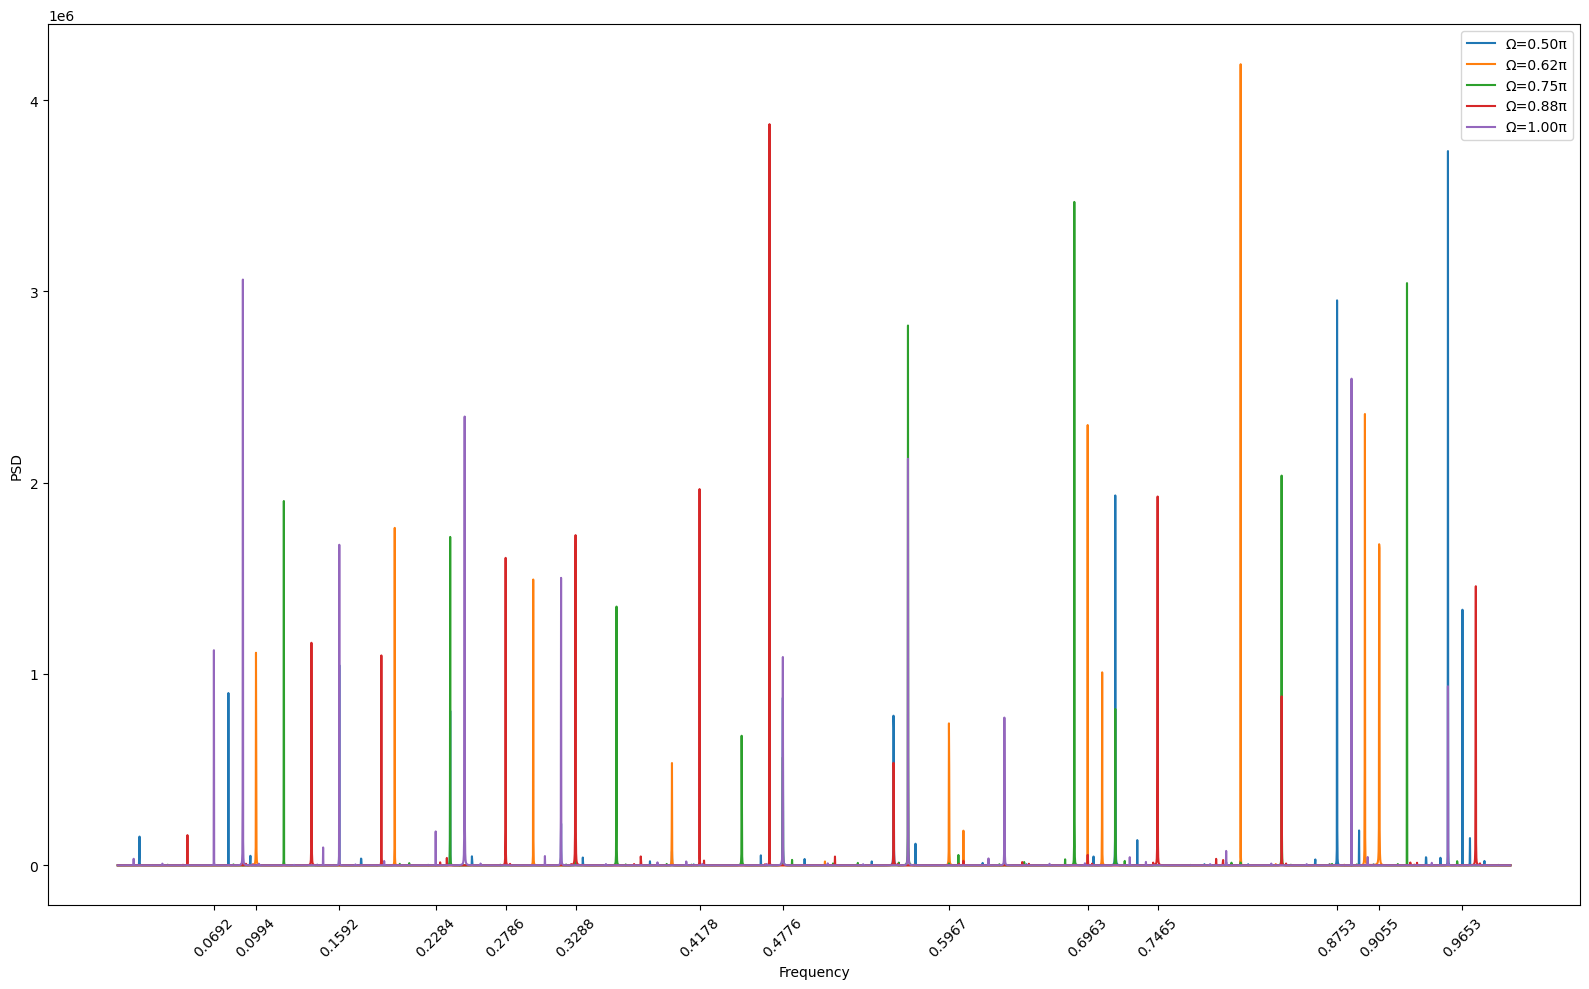


Spectral Peaks by Drive Strength:

0.50π:
  (Freq: 0.080, Amp: 9.004e+05)
  (Freq: 0.159, Amp: 1.046e+06)
  (Freq: 0.239, Amp: 8.074e+05)
  (Freq: 0.318, Amp: 2.180e+05)
  (Freq: 0.478, Amp: 8.759e+05)
  (Freq: 0.557, Amp: 7.819e+05)
  (Freq: 0.716, Amp: 1.933e+06)
  (Freq: 0.875, Amp: 2.953e+06)
  (Freq: 0.886, Amp: 2.197e+05)
  (Freq: 0.955, Amp: 3.733e+06)
  (Freq: 0.965, Amp: 1.336e+06)

0.62π:
  (Freq: 0.099, Amp: 1.111e+06)
  (Freq: 0.199, Amp: 1.764e+06)
  (Freq: 0.298, Amp: 1.494e+06)
  (Freq: 0.398, Amp: 5.346e+05)
  (Freq: 0.597, Amp: 7.418e+05)
  (Freq: 0.696, Amp: 2.301e+06)
  (Freq: 0.707, Amp: 1.009e+06)
  (Freq: 0.806, Amp: 4.187e+06)
  (Freq: 0.895, Amp: 2.359e+06)
  (Freq: 0.906, Amp: 1.678e+06)

0.75π:
  (Freq: 0.119, Amp: 1.904e+06)
  (Freq: 0.239, Amp: 1.716e+06)
  (Freq: 0.358, Amp: 1.352e+06)
  (Freq: 0.448, Amp: 6.772e+05)
  (Freq: 0.478, Amp: 5.643e+05)
  (Freq: 0.567, Amp: 2.822e+06)
  (Freq: 0.687, Amp: 3.468e+06)
  (Freq: 0.716, Amp: 8.173e+05)
  (Freq: 0.83

In [10]:
rabi_list = np.linspace(0.5, 1, 5)* np.pi

freqs, psd_results, results_summary, all_peak_freqs = compute_psd_and_peaks(omega_0,rabi_list,theta,psi0,solver,tlist)
plot_psd_and_print_peaks(freqs,psd_results,results_summary,all_peak_freqs,rabi_list,omega_d)

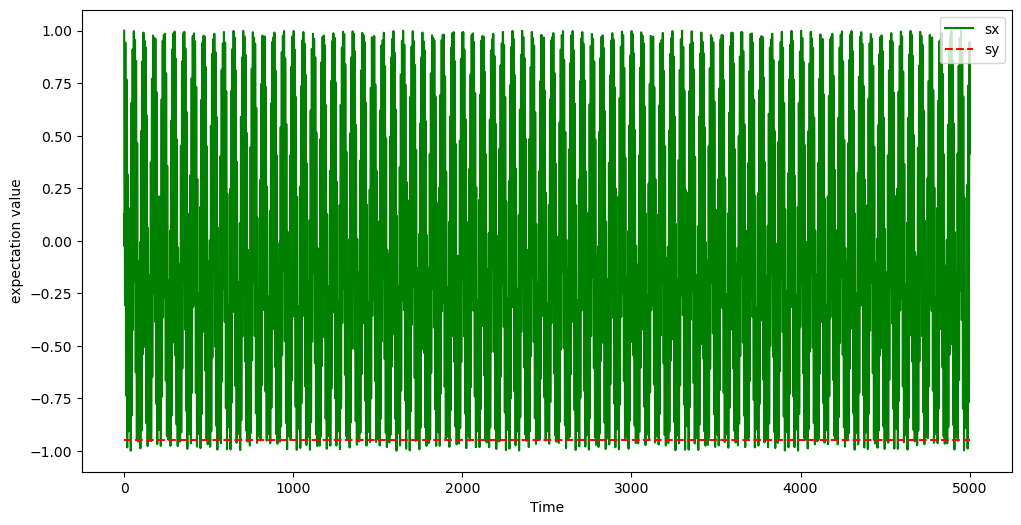

In [11]:
# Playground - Strong Drive Strengths:

# MODIFY ONLY THE BELOW LINE ------
rabi_strength = np.pi * 0.9903
# MODIFY ONLY THE ABOVE LINE ------

omega_d = rabi_strength / (2 * np.pi)
_, _, sz_brwa_d = qubit_integrate_labframe(omega_0, omega_d, rabi, theta, psi0,"me", g1, g2)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(tlist, np.real(sz_brwa_d), 'g')
ax.plot((np.min(tlist),np.max(tlist)),(-0.95, -0.95), 'r--' )
ax.legend(("sx", "sy", "sz"))
ax.set_xlabel('Time')
ax.set_ylabel('expectation value');

#### Transversal Field Results

## Non-transversal Scenarios

### Scenario 1: π / 4

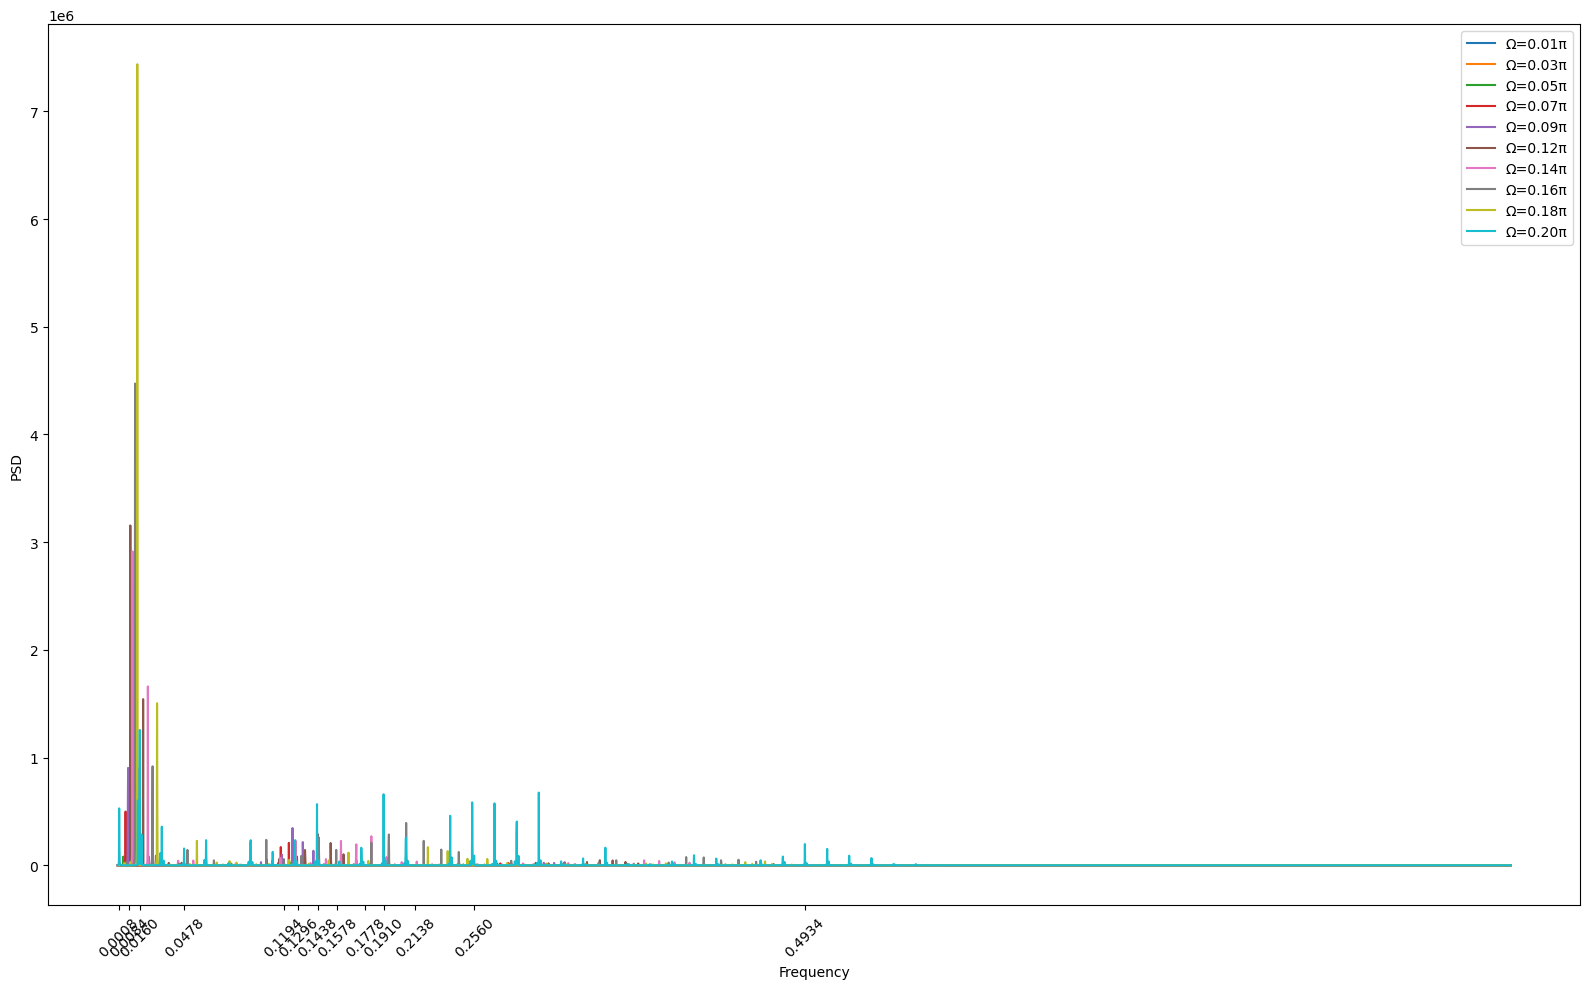


Spectral Peaks by Drive Strength:

0.01π:
  (Freq: 0.001, Amp: 5.417e+00)
  (Freq: 0.002, Amp: 7.834e+01)
  (Freq: 0.154, Amp: 8.617e+00)
  (Freq: 0.155, Amp: 2.061e+01)
  (Freq: 0.155, Amp: 4.243e+01)
  (Freq: 0.156, Amp: 6.109e+01)
  (Freq: 0.157, Amp: 6.191e+01)
  (Freq: 0.158, Amp: 3.131e+01)
  (Freq: 0.159, Amp: 7.212e+00)
  (Freq: 0.160, Amp: 2.028e+01)
  (Freq: 0.161, Amp: 8.140e+00)
  (Freq: 0.163, Amp: 8.417e+00)
  (Freq: 0.175, Amp: 4.551e+00)
  (Freq: 0.178, Amp: 9.463e+00)
  (Freq: 0.179, Amp: 1.172e+01)
  (Freq: 0.180, Amp: 9.697e+00)
  (Freq: 0.181, Amp: 2.011e+01)
  (Freq: 0.182, Amp: 2.233e+01)
  (Freq: 0.182, Amp: 1.648e+01)
  (Freq: 0.183, Amp: 1.071e+01)
  (Freq: 0.184, Amp: 6.359e+00)

0.03π:
  (Freq: 0.002, Amp: 2.632e+03)
  (Freq: 0.005, Amp: 7.269e+03)
  (Freq: 0.007, Amp: 4.310e+02)
  (Freq: 0.127, Amp: 3.771e+02)
  (Freq: 0.130, Amp: 1.543e+03)
  (Freq: 0.132, Amp: 3.791e+03)
  (Freq: 0.135, Amp: 2.852e+03)
  (Freq: 0.137, Amp: 6.021e+03)
  (Freq: 0.139, Amp: 

In [12]:
theta = np.pi / 4

# Upper limit of 10 because mpl cycle colors afterwards
rabi_list = np.linspace(0.01, 0.20, 10) * np.pi

freqs, psd_results, results_summary, all_peak_freqs = compute_psd_and_peaks(omega_0,rabi_list,theta,psi0,solver,tlist)
plot_psd_and_print_peaks(freqs,psd_results,results_summary,all_peak_freqs,rabi_list,omega_d)

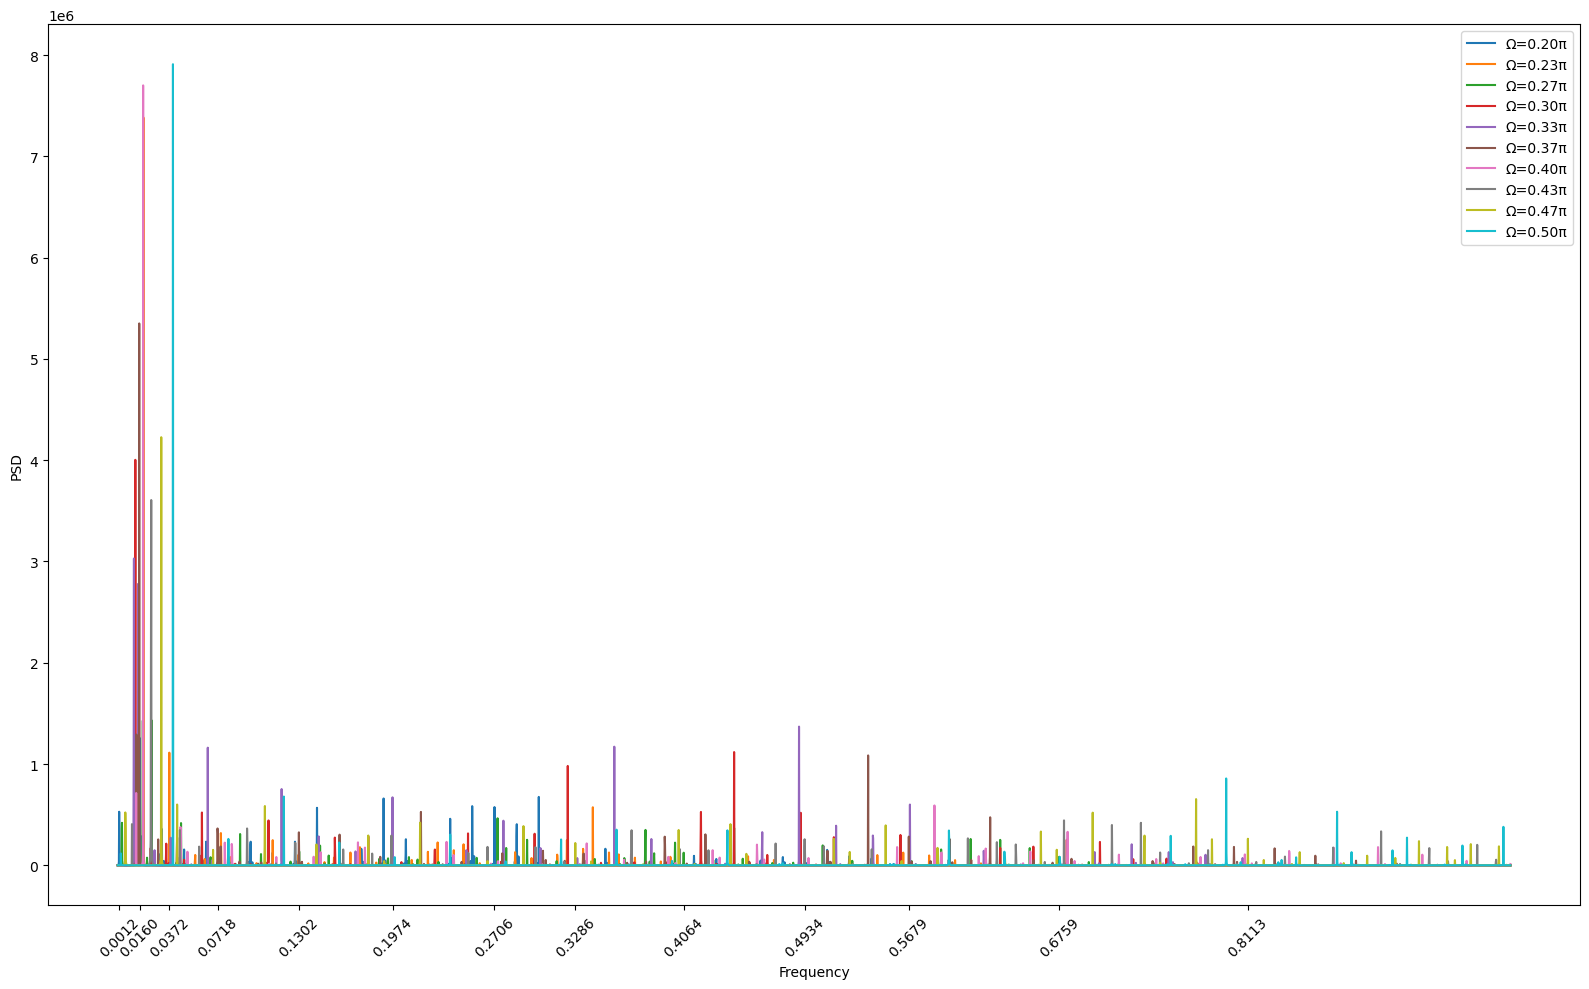


Spectral Peaks by Drive Strength:

0.20π:
  (Freq: 0.001, Amp: 5.287e+05)
  (Freq: 0.015, Amp: 6.025e+05)
  (Freq: 0.016, Amp: 1.257e+06)
  (Freq: 0.017, Amp: 2.859e+05)
  (Freq: 0.031, Amp: 1.113e+05)
  (Freq: 0.032, Amp: 3.584e+05)
  (Freq: 0.048, Amp: 1.559e+05)
  (Freq: 0.064, Amp: 2.334e+05)
  (Freq: 0.096, Amp: 2.330e+05)
  (Freq: 0.111, Amp: 1.247e+05)
  (Freq: 0.127, Amp: 2.330e+05)
  (Freq: 0.143, Amp: 5.678e+05)
  (Freq: 0.175, Amp: 1.631e+05)
  (Freq: 0.191, Amp: 6.598e+05)
  (Freq: 0.207, Amp: 2.572e+05)
  (Freq: 0.239, Amp: 4.592e+05)
  (Freq: 0.240, Amp: 7.229e+04)
  (Freq: 0.255, Amp: 5.842e+05)
  (Freq: 0.256, Amp: 8.932e+04)
  (Freq: 0.271, Amp: 5.750e+05)
  (Freq: 0.287, Amp: 4.057e+05)
  (Freq: 0.288, Amp: 8.756e+04)
  (Freq: 0.302, Amp: 6.752e+05)
  (Freq: 0.334, Amp: 6.328e+04)
  (Freq: 0.350, Amp: 1.632e+05)
  (Freq: 0.414, Amp: 9.337e+04)
  (Freq: 0.478, Amp: 8.126e+04)
  (Freq: 0.493, Amp: 1.972e+05)
  (Freq: 0.509, Amp: 1.522e+05)
  (Freq: 0.525, Amp: 8.863e+0

In [13]:
rabi_list = np.linspace(0.2, 0.5, 10) * np.pi

freqs, psd_results, results_summary, all_peak_freqs = compute_psd_and_peaks(omega_0,rabi_list,theta,psi0,solver,tlist)
plot_psd_and_print_peaks(freqs,psd_results,results_summary,all_peak_freqs,rabi_list,omega_d)

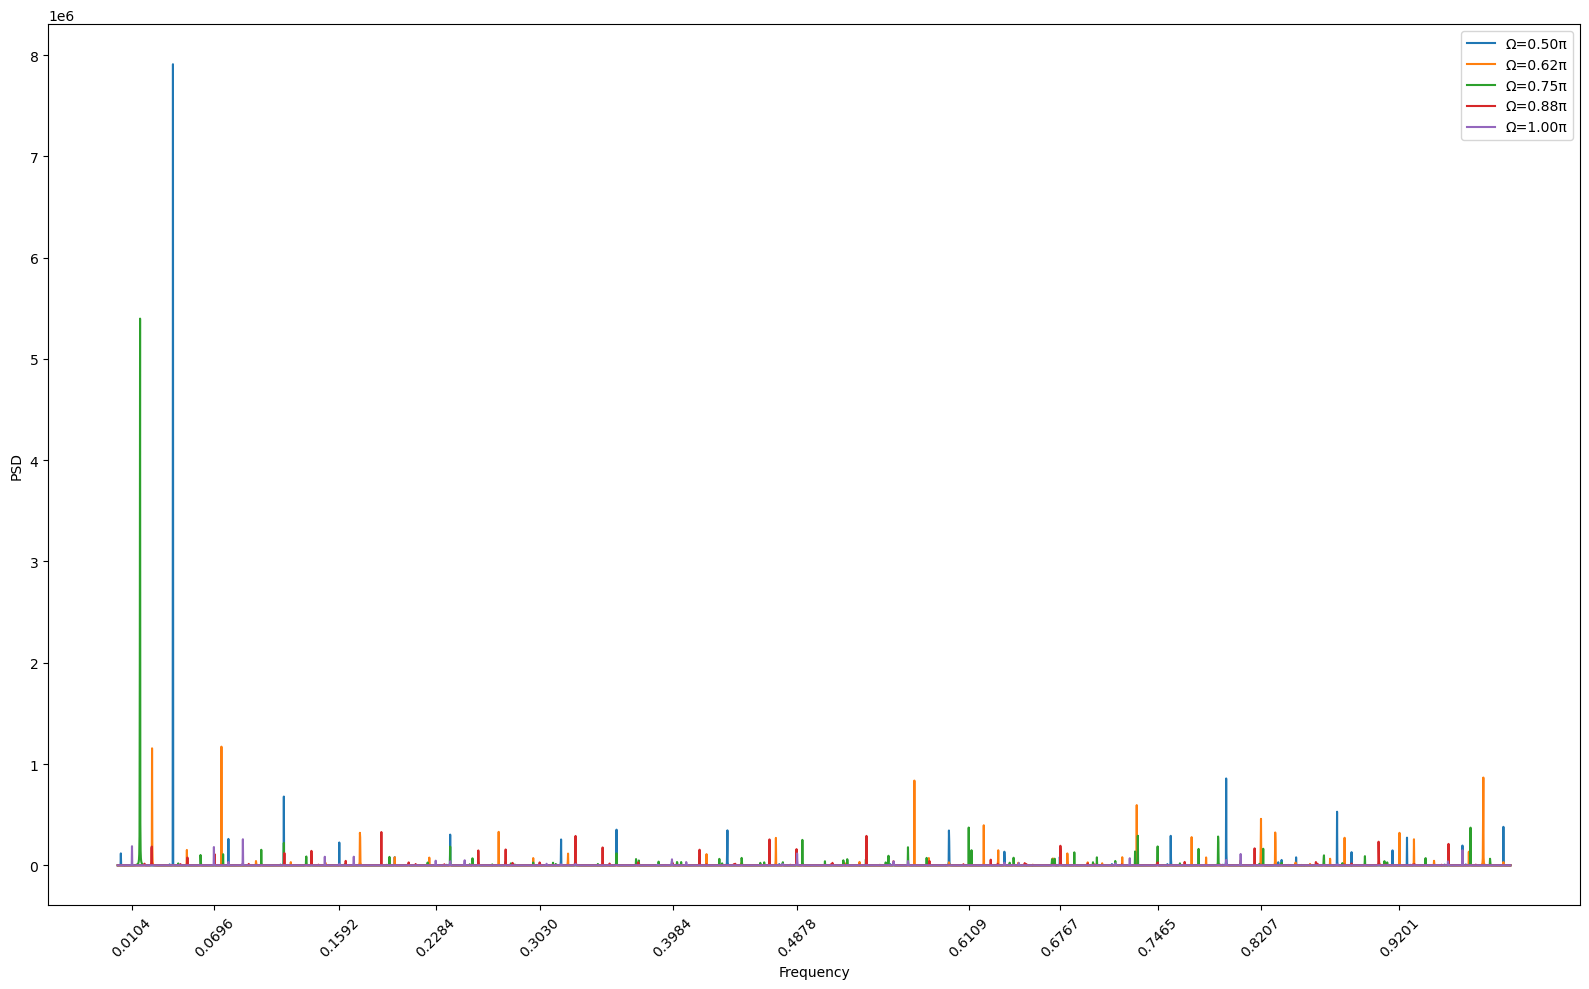


Spectral Peaks by Drive Strength:

0.50π:
  (Freq: 0.040, Amp: 7.910e+06)
  (Freq: 0.119, Amp: 6.787e+05)
  (Freq: 0.796, Amp: 8.574e+05)
  (Freq: 0.875, Amp: 5.289e+05)

0.62π:
  (Freq: 0.025, Amp: 1.155e+06)
  (Freq: 0.050, Amp: 1.514e+05)
  (Freq: 0.075, Amp: 1.172e+06)
  (Freq: 0.174, Amp: 3.208e+05)
  (Freq: 0.199, Amp: 7.938e+04)
  (Freq: 0.224, Amp: 7.594e+04)
  (Freq: 0.274, Amp: 3.303e+05)
  (Freq: 0.298, Amp: 7.130e+04)
  (Freq: 0.323, Amp: 1.155e+05)
  (Freq: 0.423, Amp: 1.102e+05)
  (Freq: 0.473, Amp: 2.706e+05)
  (Freq: 0.572, Amp: 8.365e+05)
  (Freq: 0.582, Amp: 7.132e+04)
  (Freq: 0.622, Amp: 3.952e+05)
  (Freq: 0.632, Amp: 1.485e+05)
  (Freq: 0.671, Amp: 6.762e+04)
  (Freq: 0.682, Amp: 1.170e+05)
  (Freq: 0.721, Amp: 7.976e+04)
  (Freq: 0.732, Amp: 5.943e+05)
  (Freq: 0.771, Amp: 2.781e+05)
  (Freq: 0.781, Amp: 7.749e+04)
  (Freq: 0.821, Amp: 4.585e+05)
  (Freq: 0.831, Amp: 3.240e+05)
  (Freq: 0.870, Amp: 6.464e+04)
  (Freq: 0.881, Amp: 2.717e+05)
  (Freq: 0.920, Amp: 

In [14]:
rabi_list = np.linspace(0.5, 1, 5)* np.pi

freqs, psd_results, results_summary, all_peak_freqs = compute_psd_and_peaks(omega_0,rabi_list,theta,psi0,solver,tlist)
plot_psd_and_print_peaks(freqs,psd_results,results_summary,all_peak_freqs,rabi_list,omega_d)

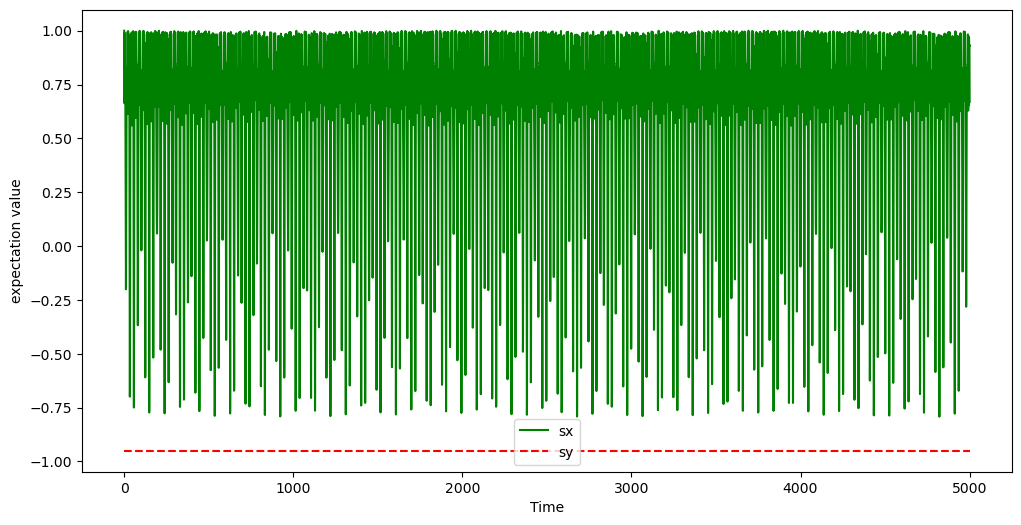

In [15]:
# Playground - All Drive Strengths:

# MODIFY ONLY THE BELOW LINE ------
rabi_strength = np.pi * 0.5513
# MODIFY ONLY THE ABOVE LINE ------

omega_d = rabi_strength / (2 * np.pi)
_, _, sz_brwa_d = qubit_integrate_labframe(omega_0, omega_d, rabi, theta, psi0,"me", g1, g2)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(tlist, np.real(sz_brwa_d), 'g')
ax.plot((np.min(tlist),np.max(tlist)),(-0.95, -0.95), 'r--' )
ax.legend(("sx", "sy", "sz"))
ax.set_xlabel('Time')
ax.set_ylabel('expectation value');